# Import pacakges

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
from econml.dml import LinearDML
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference


/opt/anaconda3/envs/xnlp/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/anaconda3/envs/xnlp/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/anaconda3/envs/xnlp/lib/python3.11/site-packages/shap/utils/_clustering.py:62: NumbaDepre

# Import data set

In [3]:
XNLP_full_data_quant_processed = pd.read_csv('data/EMNLP_merged_Qualtrics_numeric_and_Prolific_allRaces_cleaned_with_all_Metrics.csv')

In [4]:
XNLP_full_data_quant_processed_green = XNLP_full_data_quant_processed[(XNLP_full_data_quant_processed['Quality_flag']=='green')| (XNLP_full_data_quant_processed['Quality_flag']=='yellow')]

In [5]:
XNLP_full_data_quant_processed_green = pd.get_dummies(XNLP_full_data_quant_processed_green, columns=['Explanation_style'])

In [6]:
XNLP_full_data_quant_processed_green[['Prolific_Age', 'Prolific_Sex','Prolific_Employment_status']] = XNLP_full_data_quant_processed_green[['Prolific_Age', 'Prolific_Sex','Prolific_Employment_status']].replace('CONSENT_REVOKED',np.nan)

In [7]:
XNLP_full_data_quant_processed_green = pd.get_dummies(XNLP_full_data_quant_processed_green, columns=['Prolific_Sex','Prolific_Employment_status'])

In [8]:
XNLP_full_data_quant_processed['Prolific_Employment_status'].value_counts()

Full-Time                                                   98
DATA_EXPIRED                                                77
Part-Time                                                   30
Unemployed (and job seeking)                                29
CONSENT_REVOKED                                             22
Not in paid work (e.g. homemaker', 'retired or disabled)    18
Other                                                       11
Due to start a new job within the next month                 1
Name: Prolific_Employment_status, dtype: int64

In [9]:
XNLP_full_data_quant_processed_green.columns.values

array(['Quality_flag', 'Bias-start_1', 'Bias-start_2', 'Bias-start_3',
       'Bias-start-rationale', 'Disc-start_1', 'Disc-start_2',
       'Disc-start_3', 'Disc-start_4', 'Disc-start_5', 'Disc-start_6',
       'Disc-start-rationale', 'IndFair-1', 'IndFair-2', 'IndFair-3',
       'IndFair-4', 'IndFair-5', 'IndFair-6', 'IndFair-7', 'IndFair-8',
       'IndFair-9', 'Disc-end_1', 'Disc-end_2', 'Disc-end_3',
       'Disc-end_4', 'Disc-end_5', 'Disc-end_6', 'Disc-end-rationale',
       'Bias-end_1', 'Bias-end_2', 'Bias-end_3', 'Bias-end_4',
       'Bias-end-rationale', 'Percv-work_1', 'Percv-work_2',
       'Percv-work_3', 'Percv-work_4', 'Percv-work_5', 'Percv-work_6',
       'Percv-work-rationale', 'Asian_race', 'Prolific_Total_approvals',
       'Prolific_Fluent_languages', 'Prolific_Age',
       'Prolific_Ethnicity_simplified', 'Prolific_Country_of_birth',
       'Prolific_Country_of_residence', 'Prolific_Nationality',
       'Prolific_Language', 'Prolific_Student_status',
       'Time

In [10]:
XNLP_full_data_quant_processed_green['Prolific_Age'].replace('DATA_EXPIRED', np.nan, inplace=True)
XNLP_full_data_quant_processed_green['Prolific_Age'] = XNLP_full_data_quant_processed_green['Prolific_Age'].astype(float)

In [11]:
XNLP_full_data_quant_processed_green['Prolific_Employment_status_Full-Time'].value_counts()

0    186
1     97
Name: Prolific_Employment_status_Full-Time, dtype: int64

In [12]:
XNLP_full_data_quant_processed_green_subset = XNLP_full_data_quant_processed_green.dropna(subset=['Asian_race','Prolific_Age','Prolific_Sex_Female','Prolific_Employment_status_Part-Time','Prolific_Employment_status_Full-Time'])

In [13]:
# Define estimator inputs
T = XNLP_full_data_quant_processed_green_subset[['Explanation_style_CE','Explanation_style_SM']].values # intervention, or treatment
Y = XNLP_full_data_quant_processed_green_subset['stereotype_activation'].values # outcome of interest
X_data = XNLP_full_data_quant_processed_green_subset[['Asian_race','Prolific_Age','Prolific_Sex_Female','Prolific_Employment_status_Part-Time','Prolific_Employment_status_Full-Time']].values# features

In [14]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML

est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [15]:
X_data

array([[ 1., 29.,  1.,  0.,  1.],
       [ 0., 33.,  0.,  0.,  0.],
       [ 0., 32.,  0.,  0.,  1.],
       ...,
       [ 1., 35.,  0.,  0.,  1.],
       [ 0., 57.,  0.,  0.,  0.],
       [ 0., 70.,  1.,  0.,  1.]])

In [16]:
est.fit(X_data, T, Y)

CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=400,
             random_state=1235)

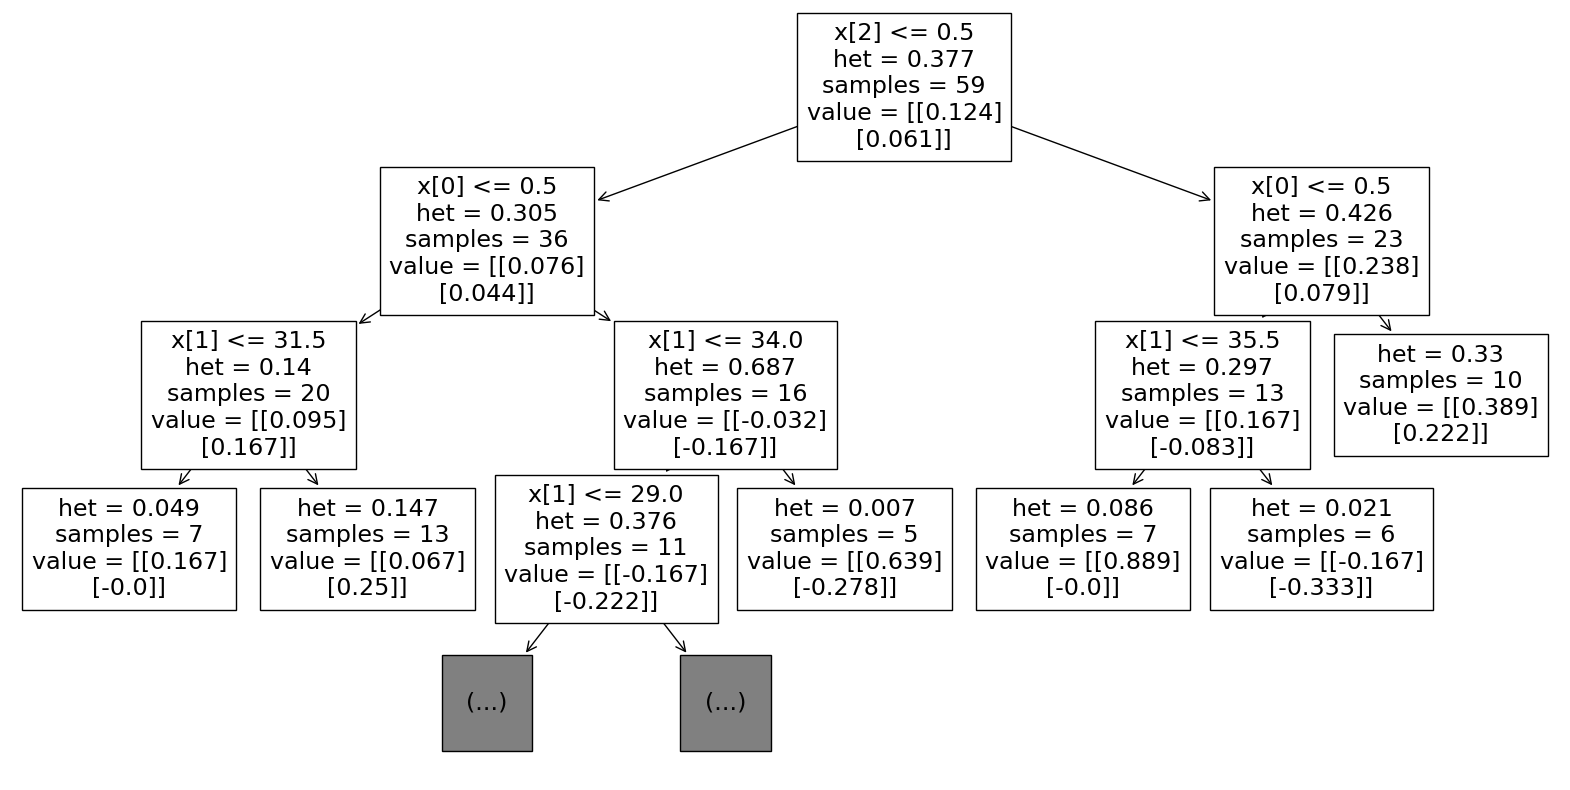

In [17]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=3)
plt.show()

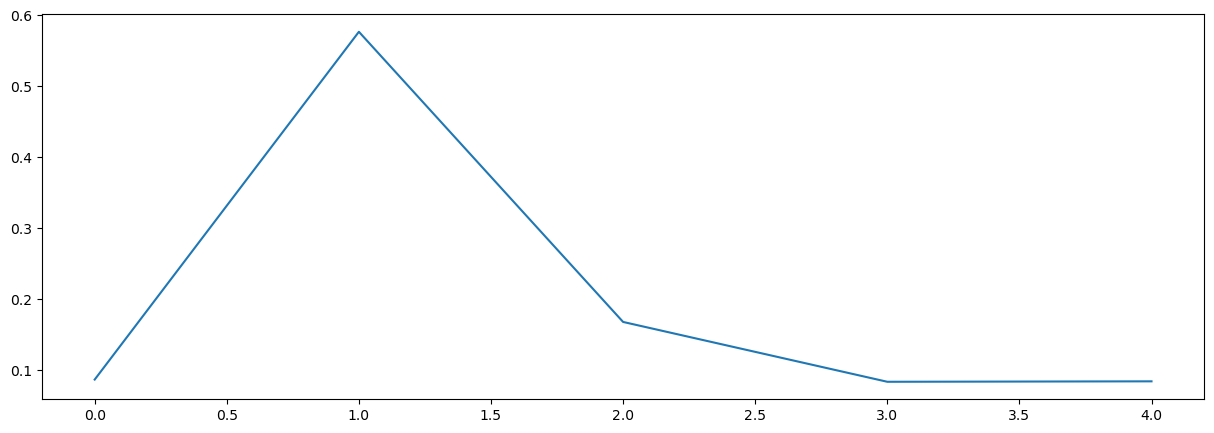

In [18]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [19]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X_data, max_samples=100))
shap_values = explainer(X_data)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


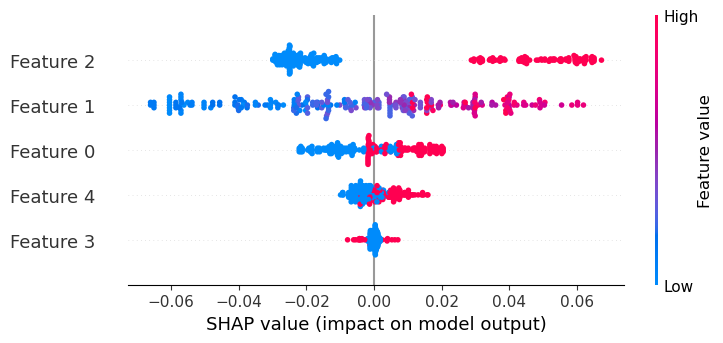

In [20]:
shap.plots.beeswarm(shap_values[:, :, 0])


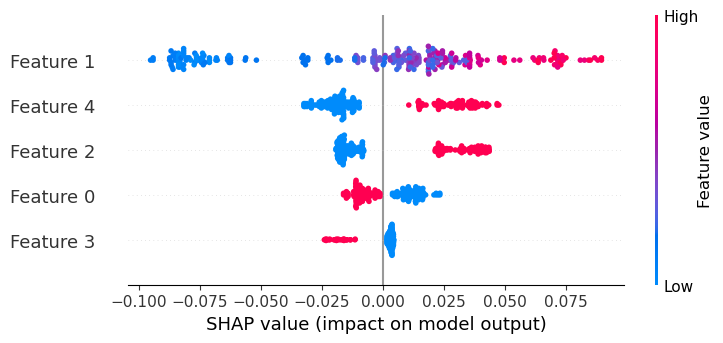

In [21]:
shap.plots.beeswarm(shap_values[:, :, 1])

In [22]:
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import LinearDML
est = LinearDML()
est.fit(Y, T, X=X_data, W=None)
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=5)
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(est, X_data)

In [23]:
plt.figure(figsize=(20, 10))
intrp.plot(feature_names=['Asian_race','Prolific_Age','Prolific_Sex_Female','Prolific_Employment_status_Part-Time','Prolific_Employment_status_Full-Time'], fontsize=12)
plt.savefig('plot/causal_analysis.pdf', dpi=300, bbox_inches='tight')

In [24]:
shap_values = est.shap_values(X_data)

# global view: explain hetergoeneity for a sample of dataset
plt.figure(figsize=(20, 10))
shap.summary_plot(shap_values['Y0']['T0'])
plt.savefig('plot/causal_analysis_shap0.pdf', dpi=300, bbox_inches='tight')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [25]:
# global view: explain hetergoeneity for a sample of dataset
plt.figure(figsize=(20, 10))
shap.summary_plot(shap_values['Y0']['T1'])
plt.savefig('plot/causal_analysis_shap1.pdf', dpi=300, bbox_inches='tight')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
